<a href="https://colab.research.google.com/github/yshnxd/solaris/blob/main/Copy_of_Solaris_11_Stable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Libraries

In [1]:
# Install yfinance if not already installed
!pip install yfinance --upgrade --quiet

# Import core libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=daeb44521ccf2fde4bb2bfe0a30f0c74a1c5bacd0083c3bb7699ef7528ab936d
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


# Collect Data

In [2]:
from datetime import datetime, timedelta
import yfinance as yf

end_date = datetime.today()
start_date = end_date - timedelta(days=729)

data = yf.download("AAPL", start=start_date.strftime('%Y-%m-%d'),
                   end=end_date.strftime('%Y-%m-%d'),
                   interval="1h")

print(data.shape)

# Flatten column names if they’re multi-level
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

/tmp/ipython-input-816293874.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start=start_date.strftime('%Y-%m-%d'),
[*********************100%***********************]  1 of 1 completed

(3473, 5)


#eature Creation

Creating Features

In [3]:
import numpy as np
import pandas as pd

from ta.trend import MACD, ADXIndicator, EMAIndicator, CCIIndicator
from ta.momentum import RSIIndicator, StochRSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, MFIIndicator


def build_features(
    data: pd.DataFrame,
    horizon: int = 1,          # predict t+1 by default
    rsi_window: int = 14,
    bb_window: int = 20,
    ma_windows = (5, 10, 20, 50, 100, 200),
    vol_windows = (10, 20),
) -> pd.DataFrame:
    """
    Expects columns: ['Open','High','Low','Close','Volume'] and a DatetimeIndex (or a 'Date' column).
    Returns a DataFrame with engineered features + future price/dir labels.
    """

    df = data.copy()

    # Ensure datetime index
    if 'Date' in df.columns and not isinstance(df.index, pd.DatetimeIndex):
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

    # ---------- Basic returns ----------
    df['ret_1'] = df['Close'].pct_change()
    df['log_ret'] = np.log1p(df['ret_1'])

    for w in vol_windows:
        df[f'vol_{w}'] = df['log_ret'].rolling(w).std()

    # ---------- Moving Averages / EMAs ----------
    for w in ma_windows:
        df[f'SMA_{w}'] = df['Close'].rolling(window=w).mean()
        df[f'EMA_{w}'] = df['Close'].ewm(span=w, adjust=False).mean()

    # ---------- RSI ----------
    rsi = RSIIndicator(close=df['Close'], window=rsi_window)
    df[f'RSI_{rsi_window}'] = rsi.rsi()

    # ---------- StochRSI ----------
    stoch = StochRSIIndicator(close=df['Close'], window=rsi_window, smooth1=3, smooth2=3)
    df['StochRSI'] = stoch.stochrsi()
    df['StochRSI_k'] = stoch.stochrsi_k()
    df['StochRSI_d'] = stoch.stochrsi_d()

    # ---------- MACD ----------
    macd = MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['MACD_hist'] = macd.macd_diff()

    # ---------- Bollinger Bands ----------
    bb = BollingerBands(close=df['Close'], window=bb_window, window_dev=2)
    df['BB_upper'] = bb.bollinger_hband()
    df['BB_lower'] = bb.bollinger_lband()
    df['BB_bandwidth'] = (df['BB_upper'] - df['BB_lower']) / df['Close']

    # ---------- ATR ----------
    atr = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['ATR_14'] = atr.average_true_range()

    # ---------- ADX ----------
    adx = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['ADX_14'] = adx.adx()
    df['ADX_pos'] = adx.adx_pos()
    df['ADX_neg'] = adx.adx_neg()

    # ---------- CCI ----------
    cci = CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20)
    df['CCI_20'] = cci.cci()

    # ---------- Volume-based ----------
    df['Vol_Pct_Change'] = df['Volume'].pct_change()
    for w in (10, 20):
        df[f'Vol_MA_{w}'] = df['Volume'].rolling(w).mean()
        df[f'Vol_zscore_{w}'] = (df['Volume'] - df[f'Vol_MA_{w}']) / df['Volume'].rolling(w).std()

    obv = OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume'])
    df['OBV'] = obv.on_balance_volume()

    mfi = MFIIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=14)
    df['MFI_14'] = mfi.money_flow_index()

    # ---------- Price structure ----------
    df['HL_range'] = df['High'] - df['Low']
    df['OC_range'] = df['Close'] - df['Open']

    # ---------- Lags ----------
    for lag in [1, 2, 3, 5, 10]:
        df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
        df[f'ret_lag_{lag}'] = df['ret_1'].shift(lag)

    # ---------- Cyclical time features ----------
    df['dow'] = df.index.dayofweek
    df['month'] = df.index.month
    df['sin_dow'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['cos_dow'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

    # ---------- Targets (for later stages) ----------
    df['future_close'] = df['Close'].shift(-horizon)
    df['future_ret'] = (df['future_close'] - df['Close']) / df['Close']
    df['direction'] = (df['future_close'] > df['Close']).astype(int)

    df = df.dropna().copy()
    return df

Normalization

Scaling

# Preprocessing

Normalize Features

In [4]:
# --- 1. Normalize Features ---
feature_cols = data.columns.difference(['Close'])  # All except target
target_col = 'Close'
# Fix: Clean inf and NaN before scaling
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

data_scaled = data.copy()
data_scaled[feature_cols] = scaler_features.fit_transform(data_scaled[feature_cols])
data_scaled[target_col] = scaler_target.fit_transform(data_scaled[[target_col]])

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# --- SETTINGS ---
time_step = 30


# --- 2. Create Dataset for CNN & LSTM ---
def create_cnn_lstm_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data.iloc[i:(i + time_step)].values)
        y.append(data.iloc[i + time_step][target_col])
    return np.array(X), np.array(y)

X_seq, y_seq = create_cnn_lstm_dataset(data_scaled, time_step)

# --- 3. Create Dataset for XGBoost (Tabular, No 3D) ---
def create_xgb_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data.iloc[i:(i + time_step)].values.flatten())  # Flatten time steps
        y.append(data.iloc[i + time_step][target_col])
    return np.array(X), np.array(y)

X_xgb, y_xgb = create_xgb_dataset(data_scaled, time_step)

# --- 4. Train/Test Split ---
split_index = int(len(X_seq) * 0.8)

# CNN-LSTM Inputs
X_seq_train, X_seq_test = X_seq[:split_index], X_seq[split_index:]
y_seq_train, y_seq_test = y_seq[:split_index], y_seq[split_index:]

# XGBoost Inputs
X_xgb_train, X_xgb_test = X_xgb[:split_index], X_xgb[split_index:]
y_xgb_train, y_xgb_test = y_xgb[:split_index], y_xgb[split_index:]

# --- 5. Create Direction Labels (Up = 1, Down = 0) ---
def create_direction_labels(y_true):
    return np.where(np.diff(y_true, prepend=y_true[0]) > 0, 1, 0)

y_seq_direction_train = create_direction_labels(y_seq_train)
y_seq_direction_test = create_direction_labels(y_seq_test)

y_xgb_direction_train = create_direction_labels(y_xgb_train)
y_xgb_direction_test = create_direction_labels(y_xgb_test)

# Build the Model

CNN

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Regression output
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
    return model

LSTM

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Regression output
    model.compile(optimizer='adam', loss='mae')
    return model

XGBOOST

In [8]:
from xgboost import XGBRegressor

def build_xgb_model():
    return XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        objective='reg:squarederror'
    )

# Train the model

CNN

In [9]:
cnn_model = build_cnn_model(input_shape=X_seq_train.shape[1:])

cnn_model.compile(optimizer='adam', loss='mse')
cnn_history = cnn_model.fit(
    X_seq_train, y_seq_train,
    validation_data=(X_seq_test, y_seq_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0377 - val_loss: 0.0052
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 8.7657e-04
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - val_loss: 8.7702e-04
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.00

LSTM

In [10]:
lstm_model = build_lstm_model(input_shape=X_seq_train.shape[1:])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_history = lstm_model.fit(
    X_seq_train, y_seq_train,
    validation_data=(X_seq_test, y_seq_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0258 - val_loss: 0.0023
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0011 - val_loss: 0.0047
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.1071e-04 - val_loss: 0.0024
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.6767e-04 - val_loss: 0.0030
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.6338

XGBOOST

In [11]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_reg.fit(
    X_xgb_train, y_xgb_train.ravel(),
    eval_set=[(X_xgb_test, y_xgb_test.ravel())],
    verbose=10
)

[0]	validation_0-rmse:0.08830
[10]	validation_0-rmse:0.03850
[20]	validation_0-rmse:0.02781
[30]	validation_0-rmse:0.02715
[40]	validation_0-rmse:0.02719
[50]	validation_0-rmse:0.02703
[60]	validation_0-rmse:0.02701
[70]	validation_0-rmse:0.02700
[80]	validation_0-rmse:0.02703
[90]	validation_0-rmse:0.02703
[99]	validation_0-rmse:0.02704


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

Plot

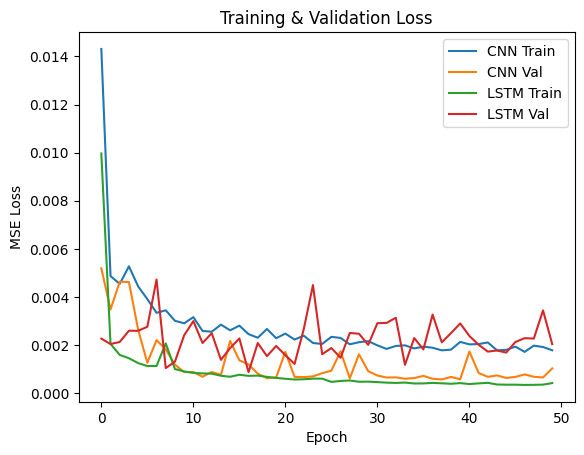

In [12]:
import matplotlib.pyplot as plt

plt.plot(cnn_history.history['loss'], label='CNN Train')
plt.plot(cnn_history.history['val_loss'], label='CNN Val')
plt.plot(lstm_history.history['loss'], label='LSTM Train')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# META LEARNER

Helper Functions

In [13]:
# === META LEARNER: Step 1 — Helpers ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import lightgbm as lgb
import joblib

# Extract window-level features from the last sequence
def extract_window_features(X_seq):
    """
    Given a sequence array (samples x timesteps x features),
    compute simple window-level stats for meta features.
    Assumes feature 0 = Close price.
    """
    n_samples, time_step, _ = X_seq.shape
    closes = X_seq[:, :, 0]
    last_price = closes[:, -1]
    prev_price = closes[:, -2]
    last_ret = (last_price - prev_price) / prev_price
    window_return = (closes[:, -1] - closes[:, 0]) / closes[:, 0]
    window_vol = np.std(np.diff(np.log1p(closes), axis=1), axis=1)
    x = np.arange(time_step)
    slope = np.apply_along_axis(lambda y: np.polyfit(x, y, 1)[0], 1, closes)
    return pd.DataFrame({
        "last_price": last_price,
        "last_ret": last_ret,
        "window_return": window_return,
        "window_vol": window_vol,
        "slope": slope
    })

Base model predictions

In [14]:
# === META LEARNER: Step 2 — Base Model Predictions ===

# Predict with each base model
cnn_preds = cnn_model.predict(X_seq_test).flatten()
lstm_preds = lstm_model.predict(X_seq_test).flatten()
xgb_preds  = xgb_reg.predict(X_xgb_test).flatten()

# Align current and actual prices
current_prices = X_seq_test[:, -1, 0][-len(cnn_preds):]
actual_prices  = y_seq_test[-len(cnn_preds):].flatten()

print("Base predictions ready. Shapes:")
print("CNN:", cnn_preds.shape, "LSTM:", lstm_preds.shape, "XGB:", xgb_preds.shape)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Base predictions ready. Shapes:
CNN: (689,) LSTM: (689,) XGB: (689,)


Feature Engineering

In [15]:
# === META LEARNER: Step 3 — Feature Engineering ===

# Base dataframe
df_meta = pd.DataFrame({
    "cnn_pred": cnn_preds,
    "lstm_pred": lstm_preds,
    "xgb_pred": xgb_preds,
    "current_price": current_prices,
    "actual_price": actual_prices
})

# Prediction deltas
df_meta["cnn_delta"] = df_meta["cnn_pred"] - df_meta["current_price"]
df_meta["lstm_delta"] = df_meta["lstm_pred"] - df_meta["current_price"]
df_meta["xgb_delta"]  = df_meta["xgb_pred"]  - df_meta["current_price"]

# Relative deltas
for model in ["cnn", "lstm", "xgb"]:
    df_meta[f"{model}_rel"] = df_meta[f"{model}_delta"] / (df_meta["current_price"] + 1e-9)

# Consensus stats
df_meta["mean_pred"] = df_meta[["cnn_pred","lstm_pred","xgb_pred"]].mean(axis=1)
df_meta["std_pred"]  = df_meta[["cnn_pred","lstm_pred","xgb_pred"]].std(axis=1)
df_meta["mean_delta"] = df_meta[["cnn_delta","lstm_delta","xgb_delta"]].mean(axis=1)
df_meta["std_delta"]  = df_meta[["cnn_delta","lstm_delta","xgb_delta"]].std(axis=1)

# Rank features
df_meta["rank_cnn"] = df_meta[["cnn_pred","lstm_pred","xgb_pred"]].rank(axis=1)["cnn_pred"]
df_meta["rank_lstm"] = df_meta[["cnn_pred","lstm_pred","xgb_pred"]].rank(axis=1)["lstm_pred"]
df_meta["rank_xgb"]  = df_meta[["cnn_pred","lstm_pred","xgb_pred"]].rank(axis=1)["xgb_pred"]

# Window-level features
win_feats = extract_window_features(X_seq_test[-len(cnn_preds):])
df_meta = pd.concat([df_meta.reset_index(drop=True), win_feats.reset_index(drop=True)], axis=1)

# Drop any NaNs
df_meta.dropna(inplace=True)
df_meta.reset_index(drop=True, inplace=True)

print("Meta feature set shape:", df_meta.shape)

Meta feature set shape: (689, 23)


Label Creation

In [16]:
# === META LEARNER: Step 4 — Label Creation ===

# Direction threshold in fractional terms (0.001 = 0.1%)
threshold = 0.001

price_series = np.concatenate([[df_meta["current_price"].iloc[0]], df_meta["actual_price"].values])
y_meta = np.where(np.diff(price_series) > threshold, 1, 0)

# Align shapes
if len(y_meta) > len(df_meta):
    y_meta = y_meta[:len(df_meta)]
elif len(y_meta) < len(df_meta):
    df_meta = df_meta.iloc[:len(y_meta)]

print("Positive (uptrend) label ratio:", np.mean(y_meta))
print("Labels shape:", y_meta.shape)

Positive (uptrend) label ratio: 0.46734397677793904
Labels shape: (689,)


Time Series CV- Training

In [23]:
# === META LEARNER: Step 1 — Prepare Features ===
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Include base model outputs, deltas, and raw technical indicators
exclude_cols = ["actual_price", "current_price", "timestamp"]
feature_columns = [c for c in df_meta.columns if c not in exclude_cols]

X_meta = df_meta[feature_columns].values

print("Meta features shape:", X_meta.shape)



Meta features shape: (689, 21)


In [24]:
# === META LEARNER: Step 2 — LightGBM Parameters ===
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation

lgb_params = {
    "objective": "binary",
    "n_estimators": 500,
    "learning_rate": 0.08,
    "num_leaves": 15,
    "min_data_in_leaf": 10,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 3,
    "random_state": 42,
    "class_weight": "balanced",
    "n_jobs": -1
}


In [25]:
# === META LEARNER: Step 3 — Cross Validation ===
tscv = TimeSeriesSplit(n_splits=3)  # fewer splits = more training samples per fold

oof_preds = np.zeros(len(y_meta))
feature_importances = np.zeros(X_meta.shape[1])

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_meta), start=1):
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(
        X_meta[train_idx], y_meta[train_idx],
        eval_set=[(X_meta[val_idx], y_meta[val_idx])],
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
    )

    p = model.predict_proba(X_meta[val_idx])[:, 1]
    oof_preds[val_idx] = p
    feature_importances += model.feature_importances_ / tscv.n_splits

    preds_bin = (p > 0.5).astype(int)
    print(f"Fold {fold} Acc: {accuracy_score(y_meta[val_idx], preds_bin):.4f} | F1: {f1_score(y_meta[val_idx], preds_bin):.4f}")

print("CV completed.")


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 85, number of negati

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Threshold Tuning and Evaluation

In [26]:
# === META LEARNER: Step 4 — Find Best Threshold for Balanced Precision & Recall ===
best_thr, best_score = 0.5, 0

for thr in np.arange(0.05, 0.95, 0.01):
    preds_bin = (oof_preds > thr).astype(int)
    prec = precision_score(y_meta, preds_bin)
    rec = recall_score(y_meta, preds_bin)
    score = 2 * (prec * rec) / (prec + rec + 1e-9)  # F1 balanced

    if score > best_score:
        best_score = score
        best_thr = thr

final_preds = (oof_preds > best_thr).astype(int)
print(f"Best threshold: {best_thr:.2f} | Balanced F1: {best_score:.4f}")


Best threshold: 0.32 | Balanced F1: 0.5670


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

In [27]:
# === META LEARNER: Step 5 — Evaluate ===
print("Accuracy:", accuracy_score(y_meta, final_preds))
print("Precision:", precision_score(y_meta, final_preds))
print("Recall:", recall_score(y_meta, final_preds))
print("Confusion matrix:\n", confusion_matrix(y_meta, final_preds))


Accuracy: 0.4746008708272859
Precision: 0.46108949416342415
Recall: 0.7360248447204969
Confusion matrix:
 [[ 90 277]
 [ 85 237]]


# save

In [19]:

# === META LEARNER: Step 7 — Final Training on All Data ===

final_model = lgb.LGBMClassifier(**lgb_params)
final_model.fit(X_meta, y_meta)

joblib.dump(final_model, "meta_lgb_model.joblib")
print("Meta model saved to meta_lgb_model.joblib")

# You can later load with:
# final_model = joblib.load("meta_lgb_model.joblib")
# probs = final_model.predict_proba(X_new)[:,1]
# preds = (probs > best_t).astype(int)

[LightGBM] [Info] Number of positive: 322, number of negative: 367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4148
[LightGBM] [Info] Number of data points in the train set: 689, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [20]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Calculate MSE for each model
cnn_mse = mean_squared_error(y_seq_test, cnn_preds)
lstm_mse = mean_squared_error(y_seq_test, lstm_preds)
xgb_mse = mean_squared_error(y_xgb_test, xgb_preds)

# Calculate RMSE by taking the square root of MSE
cnn_rmse = np.sqrt(cnn_mse)
lstm_rmse = np.sqrt(lstm_mse)
xgb_rmse = np.sqrt(xgb_mse)

# Calculate R2 score for each model
cnn_r2 = r2_score(y_seq_test, cnn_preds)
lstm_r2 = r2_score(y_seq_test, lstm_preds)
xgb_r2 = r2_score(y_xgb_test, xgb_preds)

# Print the results
print("CNN RMSE:", cnn_rmse)
print("CNN R2:", cnn_r2)
print("LSTM RMSE:", lstm_rmse)
print("LSTM R2:", lstm_r2)
print("XGB RMSE:", xgb_rmse)
print("XGB R2:", xgb_r2)

CNN RMSE: 0.0320681820755355
CNN R2: 0.8884378871320299
LSTM RMSE: 0.045148737989927246
LSTM R2: 0.7788640864537298
XGB RMSE: 0.027038544956894103
XGB R2: 0.9206887703853198
